In [1]:
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [2]:
import os
import PIL
import torch
import random 
import zipfile
import numpy as np
from torch import nn
from PIL import Image
from glob import glob
from pathlib import Path

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.empty_cache()

print(f"device: {device}")
print(torch.__version__)

device: cuda
2.1.2+cu121


In [3]:
def unzip(zip_path, image_path):
    """unzips

    Args:
        zip_path (_type_): _description_
        image_path (_type_): _description_
    """
    if Path(image_path).is_dir():
        print(f"{image_path} already exists")
    else:
        image_path.mkdir(parents=True, exist_ok=True)      
        
    if len(os.listdir(image_path)) > 0:
        print("Images already in folder") 
        pass
    else:
        with zipfile.ZipFile(zip_path, 'r') as zip_train:
            print('Unzipping Data')
            zip_train.extractall(image_path)    

In [4]:
project_directory = Path('G:/Projects/FSRCNN-2016/')

zip_data_path = Path(os.path.join(project_directory, 'zips'))
image_data_path = Path(os.path.join(project_directory, 'images'))

train_zip_path =  Path(os.path.join(zip_data_path, 'DIV2K_train_HR.zip'))
train_image_path =  Path(os.path.join(image_data_path, 'train_images'))

valid_zip_path = Path(os.path.join(zip_data_path, 'DIV2K_valid_HR.zip'))
valid_image_path = Path(os.path.join(image_data_path, 'valid_images'))

unzip(train_zip_path, train_image_path)
unzip(valid_zip_path, valid_image_path)

G:\Projects\FSRCNN-2016\images\train_images already exists
Images already in folder
G:\Projects\FSRCNN-2016\images\valid_images already exists
Images already in folder


In [5]:
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

walk_through_dir(image_data_path)

There are 2 directories and 0 images in G:\Projects\FSRCNN-2016\images
There are 1 directories and 0 images in G:\Projects\FSRCNN-2016\images\train_images
There are 0 directories and 800 images in G:\Projects\FSRCNN-2016\images\train_images\DIV2K_train_HR
There are 1 directories and 0 images in G:\Projects\FSRCNN-2016\images\valid_images
There are 0 directories and 100 images in G:\Projects\FSRCNN-2016\images\valid_images\DIV2K_valid_HR


In [6]:
image_path_list = list(train_image_path.glob("*/*.png"))
random_img = random.choice(image_path_list)

im = Image.open(random_img)
im_height = im.height
im_width = im.width
print(f"Image type is {type(im)}")
print(f"Image size is {im_height, im_width}")
# im

Image type is <class 'PIL.PngImagePlugin.PngImageFile'>
Image size is (2040, 1632)


In [7]:
from torchvision.transforms import v2, InterpolationMode
from torchvision import transforms
import matplotlib.pyplot as plt

n = 2

img_transform = v2.Compose([
    v2.ToPILImage(),
    v2.Resize(size=((int(im_height/2)), (int(im_width/2))), interpolation=InterpolationMode.BICUBIC),
    # v2.RandomPerspective(distortion_scale=0.1, p = 0.33),
    v2.RandomChoice([
    v2.RandomRotation(degrees=90),
    v2.RandomRotation(degrees=180),
    v2.RandomRotation(degrees=270),]
    # v2.RandomCrop(size=(int((int(im_height/2))*.8),int((int(im_width/2))*.8)))]
    , p=[0.33, .33, .33]),
    # v2.PILToTensor(),
    transforms.ToTensor()
                            ])

# Create the custom Dataset/DataLoader

In [8]:
from torch.utils.data import Dataset, DataLoader
from typing import Tuple
import pathlib
import cv2

class CustomDIV2K(Dataset):
    
    def __init__(self, targ_dir:str, mode: str, n: int):
        # get images from a path
        self.paths = list(pathlib.Path(targ_dir).glob(f"*/*.png"))
        # train or val or test
        self.mode = mode
        self.n = n

        
    def load_image(self, idx:int) -> Image.Image:
        image_path = self.paths[idx]
        return Image.open(image_path)
    
    def train_transform_LR_image(self, image):
        im_height = image.height
        im_width = image.width
        img_transform = v2.Compose([
            v2.ToPILImage(),
            v2.Resize(size=((int(im_height/self.n)), (int(im_width/self.n))), interpolation=InterpolationMode.BICUBIC),
            # v2.RandomPerspective(distortion_scale=0.1, p = 0.33),
            v2.RandomChoice([
            v2.RandomRotation(degrees=90),
            v2.RandomRotation(degrees=180),
            v2.RandomRotation(degrees=270)]
            , p=[0.33, .33, .33])
            ,
            v2.RandomApply([
                v2.RandomCrop(size=(int((int(im_height/self.n))*.8),int((int(im_width/self.n))*.8)))
            ], p=.3)
            ,
            v2.ToTensor(),
                                    ])
        return img_transform(image)
    
    def test_transform_LR_image(self, image):
        im_height = image.height
        im_width = image.width
        img_transform = v2.Compose([
            v2.ToPILImage(),
            v2.Resize(size=((int(im_height/self.n)), (int(im_width/self.n))), interpolation=InterpolationMode.BICUBIC),
            v2.ToTensor(),
        ])
        
    def transform_HR_image(self, image):
        img_transform = v2.Compose([
            v2.ToTensor()
        ])
        return img_transform(image)
    
    def __len__(self) -> int:
        return len(self.paths)
    
    def __getitem__(self, idx:int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns the LR and HR images given an index

        Args:
            idx (int): Index of image

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: returns images in forms of tensors
        """
        img = self.load_image(idx)
        HR = self.transform_HR_image(img).permute(1,2,0)
        
        if self.mode == 'train':
            LR = self.train_transform_LR_image(img).permute(1,2,0)
        else:
            LR = self.test_transform_LR_image(img).permute(1,2,0)
        
        return HR, LR

In [9]:
train_data_custom = CustomDIV2K(train_image_path, mode='train', n=2)

valid_data_custom = CustomDIV2K(valid_image_path, mode='valid', n=2)

print(f"Length of training data: {len(train_data_custom)}")
print(f"Length of Validation data: {len(valid_data_custom)}")

Length of training data: 800
Length of Validation data: 100


In [10]:
BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                    #  num_workers=NUM_WORKERS,
                                     shuffle=True
                                     )

valid_dataloader_custom = DataLoader(dataset=valid_data_custom,
                                     batch_size=BATCH_SIZE,
                                    #  num_workers=NUM_WORKERS,
                                     shuffle=False)

In [11]:
HR_custom, LR_custom = next(iter(train_dataloader_custom))

HR_custom.shape

g:\Anaconda\envs\pytorch\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


torch.Size([1, 1356, 2040, 3])

In [12]:
def plot_transformation(idx, dataloader, n=3):
    """
    input:
        path_list: list of paths
        transform: a transform function
        n: the number of images to display
    output:
        displays random images in pairs of the original and transformed image
    """
    random_images = random.sample(range(len(dataloader)), n)
    for img in random_images:
        fig, ax = plt.subplots(nrows=1, ncols=2)
        images = dataloader.__getitem__(img)
        # OG image
        ax[0].imshow(images[0])
        ax[0].set_title(f"Original")
        ax[0].axis(False)
        
        # Transformed image
        ax[1].imshow(images[1])
        ax[1].set_title(f"Transformed")
        ax[1].axis(False)

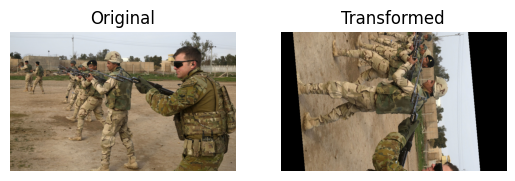

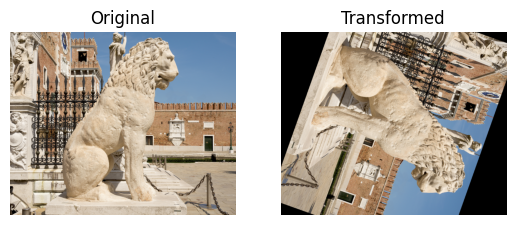

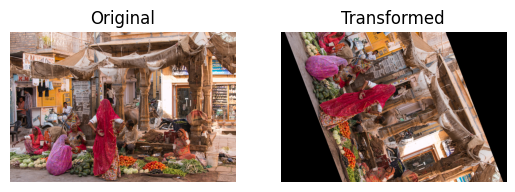

In [13]:
plot_transformation(idx=3,
                    dataloader=train_data_custom)

# Create the model 

In [14]:
from torch import nn
import numpy as np

class FSRCNN(nn.Module):
    """
    Model from https://arxiv.org/abs/1608.00367
    """
    def __init__(self, n:int, d=24, s=5, m=1):
        """
        d: LR feature dimension
        s: level of shrinking
        m: number of mapping layers
        n: scaling factor
        """
        super().__init__()
        if n < 2  and n > 5:
            raise ValueError("Scaling must be between 2 and 4 (inclusive)")
        else:
            self.n = n

        self.PReLU = nn.PReLU()
        self.Conv1 = nn.Conv2d(in_channels=1,
                               out_channels=d,
                               kernel_size=5,
                               padding=5,
                               padding_mode='zeros',
                               device=device)
        
        self.Conv2 = nn.Conv2d(in_channels=d,
                               out_channels=s,
                               kernel_size=1,
                               padding=1,
                               padding_mode='zeros',
                               device=device)
        
        self.Conv3 = nn.Conv2d(in_channels=s,
                               out_channels=s,
                               kernel_size=3,
                               padding=3,
                               padding_mode='zeros',
                               device=device)
        self.Conv4 = nn.Conv2d(in_channels=s,
                               out_channels=d,
                               kernel_size=1,
                               padding=1,
                               padding_mode='zeros',
                               device=device)
        self.DeConv = nn.ConvTranspose2d(in_channels=d,
                                         out_channels=1,
                                         kernel_size=9,
                                         padding=9,
                                         padding_mode='zeros',
                                         device=device)
        
        
    def forward(self, x):
        block1 = self.PReLU(self.Conv1(x))
        block2 = self.PReLU(self.Conv2(block1))
        # block3 = self.PReLU(self.Conv3(block2))
        block4 = self.PReLU(self.Conv4(block2))
        out = self.DeConv(block4)
        return out
        

In [15]:
model_0 = FSRCNN(2).to(device)

model_0

FSRCNN(
  (PReLU): PReLU(num_parameters=1)
  (Conv1): Conv2d(1, 24, kernel_size=(5, 5), stride=(1, 1), padding=(5, 5))
  (Conv2): Conv2d(24, 5, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (Conv3): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
  (Conv4): Conv2d(5, 24, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (DeConv): ConvTranspose2d(24, 1, kernel_size=(9, 9), stride=(1, 1), padding=(9, 9))
)

In [16]:
# single image batch
HR_single, LR_single = next(iter(train_data_custom))
HR_single.shape, HR_single.shape

(torch.Size([1404, 2040, 3]), torch.Size([1404, 2040, 3]))

In [17]:
model_0(HR_single.unsqueeze(dim=1).to(device))

tensor([[[[-0.4039, -0.3561, -0.3581],
          [-0.4140, -0.3779, -0.3733],
          [-0.4208, -0.3829, -0.3734],
          ...,
          [-0.3733, -0.3790, -0.3711],
          [-0.3710, -0.3779, -0.3693],
          [-0.3695, -0.3746, -0.3729]]],


        [[[-0.4055, -0.3491, -0.3553],
          [-0.4174, -0.3739, -0.3713],
          [-0.4242, -0.3785, -0.3713],
          ...,
          [-0.3731, -0.3788, -0.3711],
          [-0.3710, -0.3779, -0.3693],
          [-0.3695, -0.3746, -0.3729]]],


        [[[-0.4063, -0.3457, -0.3548],
          [-0.4181, -0.3716, -0.3719],
          [-0.4245, -0.3775, -0.3726],
          ...,
          [-0.3734, -0.3791, -0.3712],
          [-0.3710, -0.3779, -0.3693],
          [-0.3695, -0.3746, -0.3729]]],


        ...,


        [[[-0.3823, -0.3583, -0.3648],
          [-0.3852, -0.3649, -0.3660],
          [-0.3874, -0.3691, -0.3658],
          ...,
          [-0.3772, -0.3808, -0.3749],
          [-0.3717, -0.3785, -0.3711],
          [-0.36

# Train Model

1. first train on simple model with only downsampled training data
2. few epochs no batches
3. create my own batches by making a list of lists or something

- for an epoch in a range
- do a forward pass
- calculate the loss
- optimizer zero_grad
- loss backward
- optimizer step